---
<a name="review"></a>
## Review: 

### Bias Variance Tradeoff

![](http://www.kdnuggets.com/wp-content/uploads/bias-variance-total-error.jpg)



---
<a name="hook"> </a>

## Applications: 

**Definiton Churn Rate:**
>The annual, monthly, or weekly percentage rate at which customers stop subscribing to a service

Machine Learning is used in churn rate solutions in industry to predict, maintain, and increase user retention. 

### Amazon

[Amazon](https://www.fool.com/investing/2016/06/01/amazon-prime-improves-its-customer-retention-rate.aspx) retains more customers than Cosco through their Prime membership.
![](http://www.rokuhelp.com/wp-content/uploads/2017/02/amazon-696x311.png) 

### Uber
[Uber](http://www.sfchronicle.com/business/article/Uber-incentives-aim-to-lure-power-drivers-7089842.php) creates new incentive programs in order to help maintain driver retention. 
![Uber](http://www.slate.com/content/dam/slate/blogs/the_eye/2016/02/160203_EYE_Uber-Logos.jpg.CROP.promovar-mediumlarge.jpg)


## Our Case Study

In our case study, we will build models that can predict if a user from a cellular service company will churn. 

----

### Data Science Work Flow 

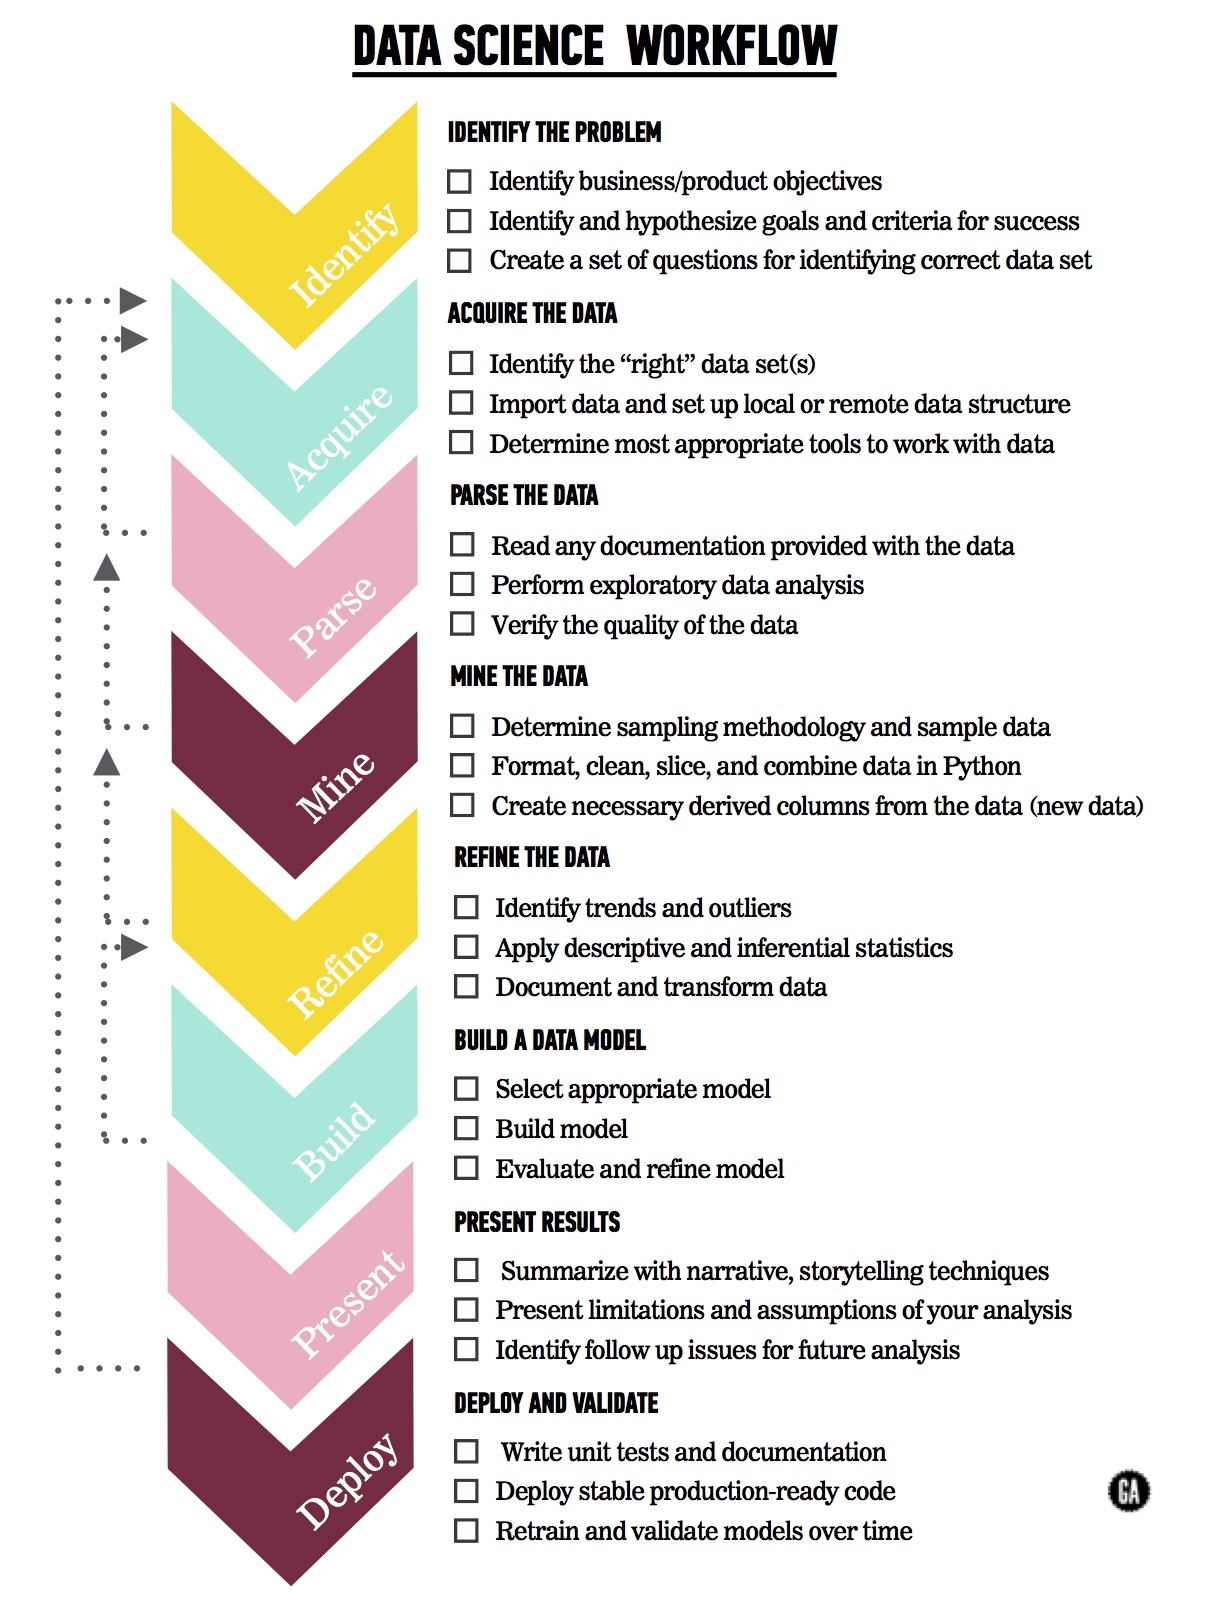

In [1]:
from IPython.display import Image
# change path to where you have the DSI 7 repo stored (I can't do that for you.)
Image(filename='/Users/Alexander/dsi-sf-7-materials/ds_workflow.jpg') 

## Check for Understanding 

1. What is the business problem that we are trying to solve?
2. Why is this business problem important?
3. The Data Science Flowchart has doted line arrows that show an iteration process between **Refining The Data** stage and the **Build A Data Model** stage. Why do you think there is an interative process here?

**IMPORTANT: MAKE SURE YOU UNDERSTAND THE ANSWERS. THEY WILL DRIVE THE FOUCS OF THIS NOTEBOOK.**

In [2]:
# write answers here

---
## **Lesson**
<a name="content"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from __future__ import division
from cross_val_tool import cross_validation

%matplotlib inline

# modeling
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter, OrderedDict

from time import sleep, time
from sklearn.grid_search import GridSearchCV

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Import and clean data 

Perform the same cleaning and scaling in preperation for modeling buidling.

In [3]:
# import data
data_path = "~/dsi-sf-7-materials/datasets/churn.csv"
df = pd.read_csv(data_path)

In [4]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
# drop irrelavent columns like area code, user phone number, Account Length
# drop State from the data frame, but first save it to a variable for latter use 
X_cols = [ u"Int'l Plan",
           u'VMail Plan', u'VMail Message', u'Day Mins', u'Day Calls',
           u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins',
           u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls',
           u'Intl Charge', u'CustServ Calls', u'Churn?']

states = df.State
df = df[X_cols]

In [6]:
# replace any positve categorical with 1 
true = ["yes",
        "True",
        "True."]
# replace any negative categorical with 0
false = ["no",
         "False",
         "False."]

df.replace(to_replace=true, value=1, inplace=True)
df.replace(to_replace=false, value=0, inplace=True)

In [7]:
# rename churn column
df.rename(columns={'Churn?':'Churn'}, 
          inplace=True)

In [8]:
# before scaling, exclude the categorical features
numerical_cols = df.columns[2:-1]

In [9]:
# columns won't rescale unless dtype = "float"
df2 = df[numerical_cols].astype(float)

In [10]:
# scale along the features
df2[numerical_cols] = df2[numerical_cols].apply(lambda x: MinMaxScaler(feature_range=(-1,1)).fit_transform(x));

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your d

In [11]:
# Move columns with boolean values back into dataframe
df2[df.columns[0]] = df[df.columns[0]].values
df2[df.columns[1]] = df[df.columns[1]].values
df2[df.columns[-1]] = df[df.columns[-1]].values

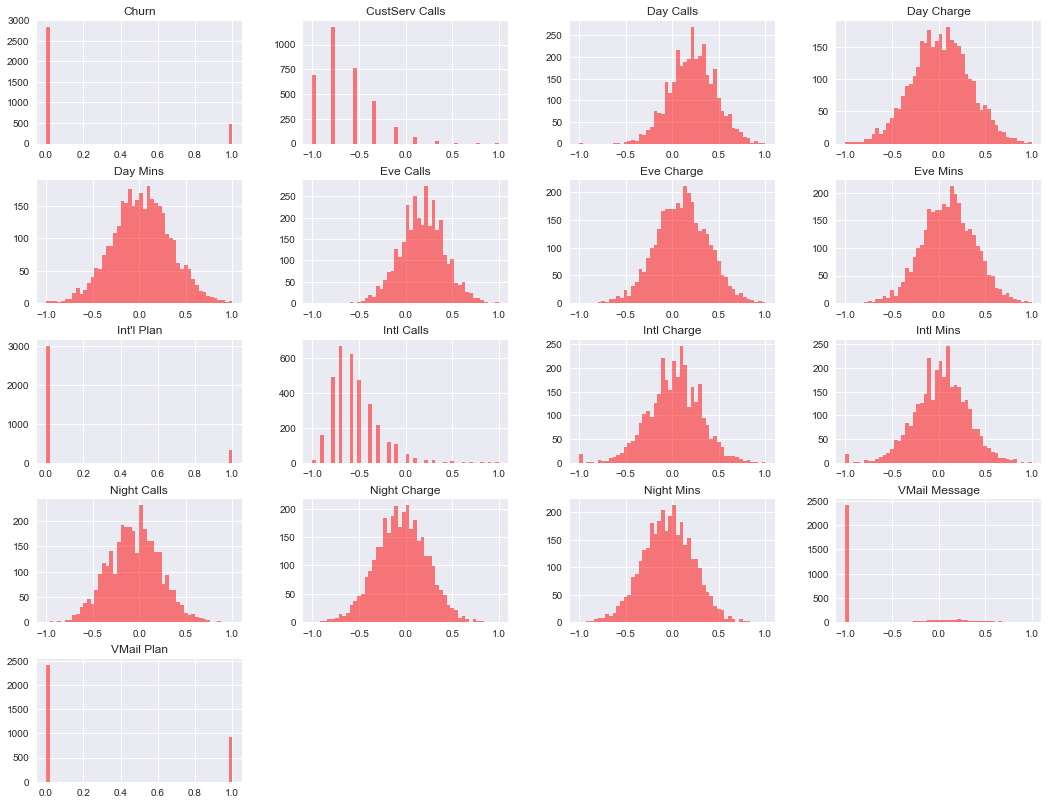

In [12]:
# Distribution of features - after rescaling
df2.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

In [13]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
0,-0.019608,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,0,1,0
1,0.019608,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,0,1,0
2,-1.000000,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,0
3,-1.000000,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,1,0,0
4,-1.000000,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,1,0,0


---


## Iterative Model Building 

We are going to iterative refine our data and feed it to our baseline model to see if our refinement has increased our model's ability to learn from the data. But first let's be clear on why we are going to use Logistic Regression as our baseline classification model and why we are going to use learning curves for our model analysis.


### Logistic Regression | Baseline Model

For our baseline model, we are going to use a Logistic Regression (LR). LR is a good choice for a classification baseline model for several reasons. First, it **doesn't require any hyper-parameters to train**, so iterating ideas on this model is fast and easy. Second, LR is the **least complex model** in our toolbox, so it is unlikely to overfit but if it does we can infer that more complex models would also overfit (so there is no need to train those more complex models -- thus saving us time!) Third, because LR is a relatively simple model, the type of **error that is likely to appear is high bias**. If the model shows high bias, this is an inication that more complex models should be used to fit the data. 


### Learning Curves | Model Performance


![](http://rocketdatascience.org/wp-content/uploads/2016/01/model_complexity_error_training_test.jpg)

**IMPORTANT: THE X-AXIS LABEL SHOULD SAY "TRAINING SET SIZE", OTHERWISE IT IS A GREAT IMAGE.**


Learning curves are a great way to asses model performance because they communicate informance about model performance that is not availabel from a single data point. 

Let's look at an example to bring this point home. Check out the following cross validation using cross_val_sore:

In [14]:
# move churn column to Y 
# move all other columns to X
x_cols = df2.columns[:-1]
X = df2[x_cols].values
Y = df2.Churn.values

# shuffle data then
X, Y = shuffle(X, Y)
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled =  train_test_split(X, Y, test_size = 0.2, random_state=1234)

In [15]:
lr = LogisticRegression(penalty='l2')
cv_socres = cross_val_score(lr, X_train_scaled, Y_train_scaled, cv=10)

In [16]:
# accuracy scores from each of the 10 folds
cv_socres

array([ 0.8576779 ,  0.86142322,  0.84644195,  0.86891386,  0.87265918,
        0.87640449,  0.8576779 ,  0.87265918,  0.86415094,  0.87169811])

In [17]:
# mean accuracy score
np.mean(cv_socres)

0.86497067345063949

### Check for Understanding

1. What can you conclude about the model's performance based on the output from cross_val_score?
2. Is it biased?
3. Is it overfitting?
4. Is the model overtraining?
5. Will the model's performance increase by increasing the size of the training set?
6. Can you answer these questions with the information provided by cross_val_score?

In [ ]:
# answer

The accuracy scores returned by cross_val_score are calculated on the test folds. The accuracy scores are consistant between folds. Which is great, it means that our model performs consistantly, regardless of what subsample of data it trains on. If this were not the case, it would have to investiage what was causing it. 

What cross_val-socres on the test set **CANNOT** communicate: 


2. Is the model overfitting?
3. Is the model overtraining?
4. Would the model's performance increase if it saw more training samples?


Fortunately, **learning curves answers all of these questoins which is why they are such a powerful model building tool!**

-----

### Custom Built Learning Cruve Tool

We are going to be using a learning curve tool that is an improvement on the [Sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html). 

Our custom tool is an improvment in the following way. While cross validating our model, it scores the model on 4 metrics (Accuracy, Precision, Recall, and F1 Score). The Sklearn version scores the model on only a single metric. Which means that we'd have to cross validate our model several times on the same data in order to get scores for all 4 metircs -- which is not a very intelligent way to do this. Also ort tool has a method that plots the learning curves of all 4 metrics for you. Pretty useful!



```python
cv = cross_validation(lr,                    # classification model
                      X_train,               # Training Predictors
                      Y_train ,              # Training Target
                      n_splits=10,           # Number of KFold splits
                      init_chunk_size = 100, # initial size of training 
                      chunk_spacings = 25,   # number of samples to increase the training set by 
                      average = "binary")    # score metrics need the type of classification average specified 


```

#### How this tool works

1. Take the number of samples from the training set as specified in init_chunk_size
2. Perform n_splits on the data
3. Score the model on the test folds and average the scores across all the folds
5. Score the model on the training set and average the scores across all the folds
4. Store the metric's average scores in a list for the training and test folds
5. Increase the training set size by the number specified in chunk_spacings
6. Repead steps 2 through 5 until all training points are included in the training set
7. Call the plot_learning_curve method to visualize the results


**NOTE: You all have the requsite knowledge to understand how this tool has been built. However, we will not go over it in class because it is not part of this lesson's learning objectives. But you can checkout the code in the cross_val_tool.py file if you're curious. **


---

## 1st Iteration | Scaled Data


First we are going to calculate the baseline accuracy. The accuarcy that we get when we guess the majority class for every sample. 

### Navie Baseline Accuracy

In [18]:
baseline_accuracy = (Y_train_scaled.size - Y_train_scaled.sum())/Y_train_scaled.size
print "Baseline Accuracy: {:.4}".format(baseline_accuracy)

Baseline Accuracy: 0.8545


Next we are going to simply pass in a scaled version of the data set. 

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


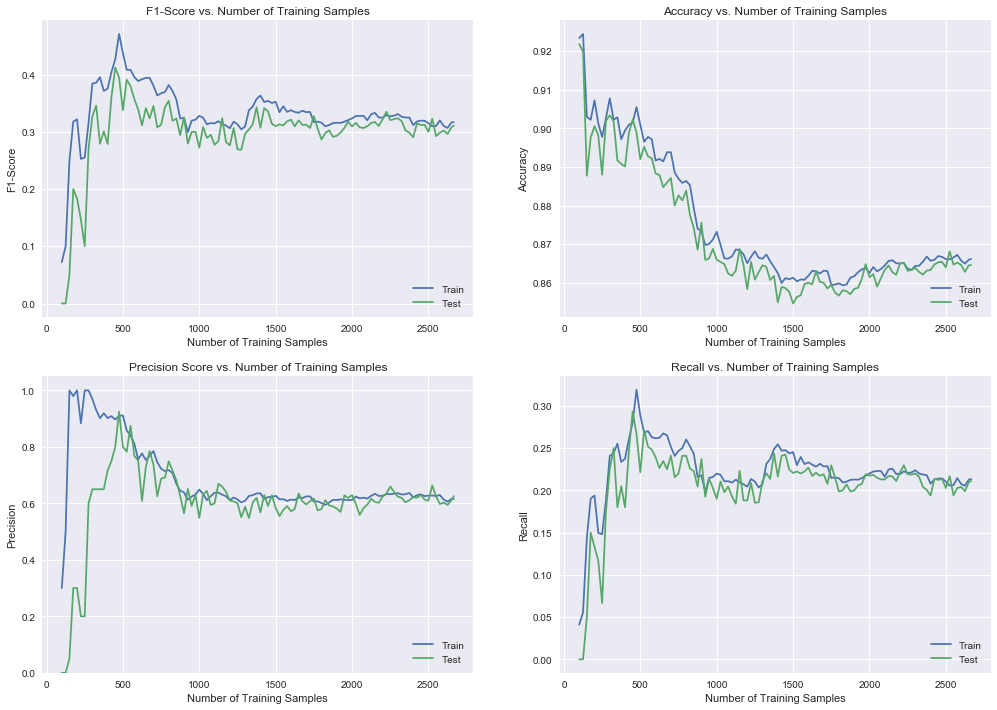

In [19]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, 
                      X_train_scaled, 
                      Y_train_scaled , 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.train_for_learning_curve()
cv.plot_learning_curve()

## Check for Understanding

1. Does the model have a high bias?
2. Does the model have a high variance?
3. Would increasing the size of the training set increase the model's performance?
4. Is the model overtraining? In order words, does the model's peak performance occur before the model is trained on the whole training set? 
5. For this case study, Precision is just as important as Accuracy. Is the model's Precision acceptable? 

1. The model is biased. As the number of training samples increases, the metric scores remain the same (they satureate). This means that the model's learning has stopped. 

2. The model is has a very low variance. This is great, the model isn't overfitting to the training set. This implies that we can use more complex model's. 

3. No. Because the metrics scores flatline after a certain training size, we can safely conclude that the performance will not increase by increasing the training set size. 

4. No, the model is not over training. Over training happens then the metric scores increase, reach a peak, then decrease. Overtraining happens once we pass that peak, at which point the model starts overfitting. 

5. The Precision score is unacceptable. The test curve shows a Precison of 60%. This means that for every 10 churn predictions, only 6 of them are True Positives and the other four are False Positives. 

## 2nd Iteration | OneHotEncoding

Next in an attempt to increase our model's learning, we are going to OneHotEncode the states column. 

In [20]:
df2["State"] = states

In [21]:
df_3 = pd.get_dummies(df2)

In [22]:
df_3.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,-0.019608,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,...,0,0,0,0,0,0,0,0,0,0
1,0.019608,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,...,0,0,0,0,0,0,0,0,0,0
2,-1.000000,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,...,0,0,0,0,0,0,0,0,0,0
3,-1.000000,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,...,0,0,0,0,0,0,0,0,0,0
4,-1.000000,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# move churn column to Y 
# move all other columns to X
x_cols = df_3.columns[:-1]
X = df_3[x_cols].drop("Churn",axis = 1).values
Y = df_3.Churn.values

X, Y = shuffle(X, Y)
X_train_onehot, X_test_onehot, Y_train_onehot, Y_test_onehot =  train_test_split(X, Y, test_size = 0.2, random_state=1234)

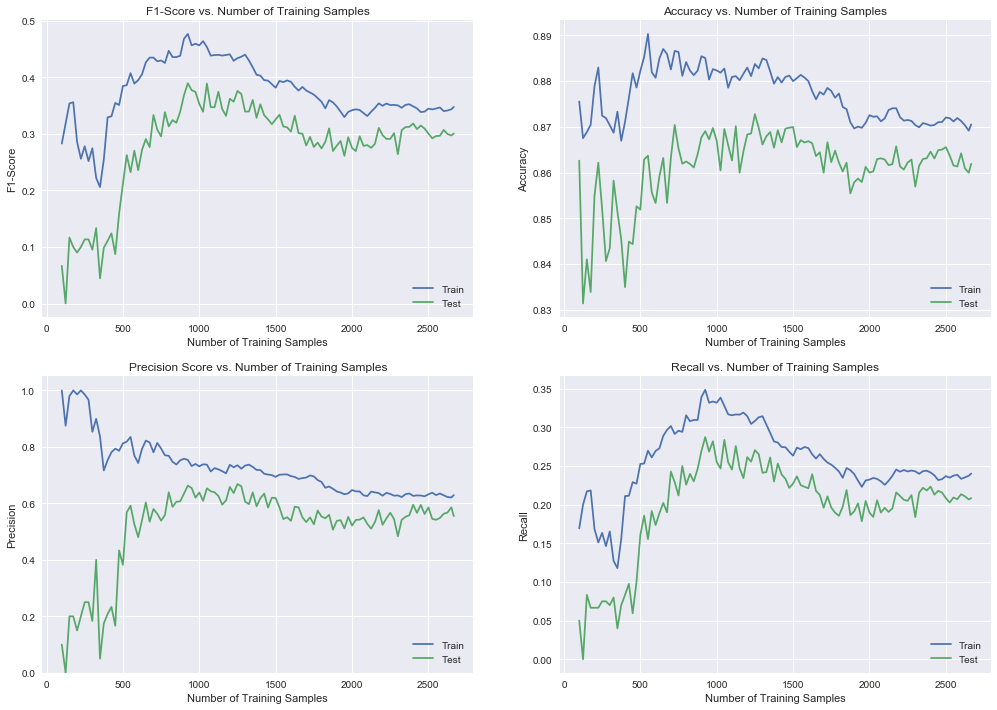

In [24]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, 
                      X_train_onehot, 
                      Y_train_onehot , 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.train_for_learning_curve()
cv.plot_learning_curve()

## Check for Understanding

1. Does the model have a high bias?
2. Does the model have a high variance?
3. Would increasing the size of the training set increase the model's performance?
4. Is the model overtraining? In order words, does the model's peak performance occur before the model is trained on the whole training set? 
5. For this case study, Precision is just as important as Accuracy. Is the model's Precision acceptable? 
6. Has OneHotEncoding the data lead to a overall better performing model?

1. The model is biased. As the number of training samples increases, the metric scores remain the same (they satureate). This means that the model's learning has stopped. 

2. This version of the data has led to a higher variance. 

3. No. Because the metrics scores flatline after a certain training size, we can safely conclude that the performance will not increase by increasing the training set size. 

4. No, the model is not over training. Over training happens then the metric scores increase, reach a peak, then decrease. Overtraining happens once we pass that peak, at which point the model starts overfitting. 

5. The Precision score is unacceptable. The test curve shows a Precison of 60%. This means that for every 10 churn predictions, only 6 of them are True Positives and the other four are False Positives. 

6. No. This version of the data has lead to model the overfit a bit. 

## 3rd Iteration | Balancing Classes

----

## Unbalanced Classes

Take a look at the Churn column. Notice that there are much more No Churn labels than Churn labels. This is to be expected: the majority of users in any given time frame usually don't cancel their subscritpion to a service, while a minority do cancel their subscription. This means that we have unbalanced classes. This class imbalance will bias our model's performance to over performing in favor of the majority class and under performing for the minority class. 

**IMPORTANT: Unbalanced data leads to biased models!**


Normally, we would have to address this issue by balancing the classes in some way. There are three common ways to do this: 

### Undersampling the Majority Class

##### Pro:
1. We can undersample the majority classs in order to obtain equal classifications. 

##### Cons:
1. The problem with this is that it will typically result in much smaller data set. 
2. Also we may be dropping important samples from the majoirty class. 

![](http://www.chioka.in/wp-content/uploads/2013/08/Undersampling.png)

### Oversampling the Minority Class

##### Pro:
1. We can oversample the minorty classs in order to obtain equal classifications. 
2. This approach will not decrease our data set size, in fact it will increase it. 

##### Cons:
1. We will have multiple copies of minority samples which may lead to overfitting

![](http://www.chioka.in/wp-content/uploads/2013/08/Oversampling.png)

###  SMOTE (Synthetic Minority Oversampling Technique)

##### Pro:
1. Generate slightly mutated copies of the minority class. 
2. Maintaining diversity in the minority class will help advoid overfitting. 
3. Increase the size of the data set

##### Cons:
1. May misrepresent the true population distribution of the minority class. 

![](http://www.chioka.in/wp-content/uploads/2013/08/SMOTE-boundary.png)

#### General idea of how SMOTE works:

![](http://www.svds.com/wp-content/uploads/2016/08/ImbalancedClasses_fig11.png)

#### Open Source package 

You don't have to code SMOTE yourself. There is an open source package, with documentation. Best of all, it has over 10 different versions of SMOTE and SMOTE-like methods that balance unbalance data sets. There are also links to the research papers behind each version. Check it out! [SMOTE Versions](https://github.com/scikit-learn-contrib/imbalanced-learn) 



The docs also have plenty of examples, with visualization, that show [How SMOTE Works](http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py)



## Check for Understanding

1. When might Undersampling the majority class actually lead to good results in a model? Would the size of the data matter?
2. Why is SMOTE an improvement on simply oversampling the minority class?

1. In the case in which we have a sufficiently large data set where the minority class has a large number of labels, it might be the case that oversampling the majority class will not leave out any imporant samples and we'll retain a good representation of the majority class distribution. For instance, let's say we have a data set with 10,000 samples. Where the majority class has 6000 samples and the minority class hass 4000 samples. In this case, it might be true that all need to train a model is 4000 samples -- or even less than that. 

2. SMOTE is an improvment on simple oversampling because it generates new minority class samples that are similar to the original samples but also slightly different. What this accomplishes is it increases the density of the distribution of the minority class with low risk the overall characteritic of that distribution. Also, this helps prevent overfitting, which is a risk in simple oversampling. 

## 3rd Iteration | Balanced Classes on Scaled & OneHotEncoded Data 

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
sm = SMOTE(kind='regular')
X_smote_onehot, Y_smote_onehot = sm.fit_sample(X_train_onehot, Y_train_onehot)

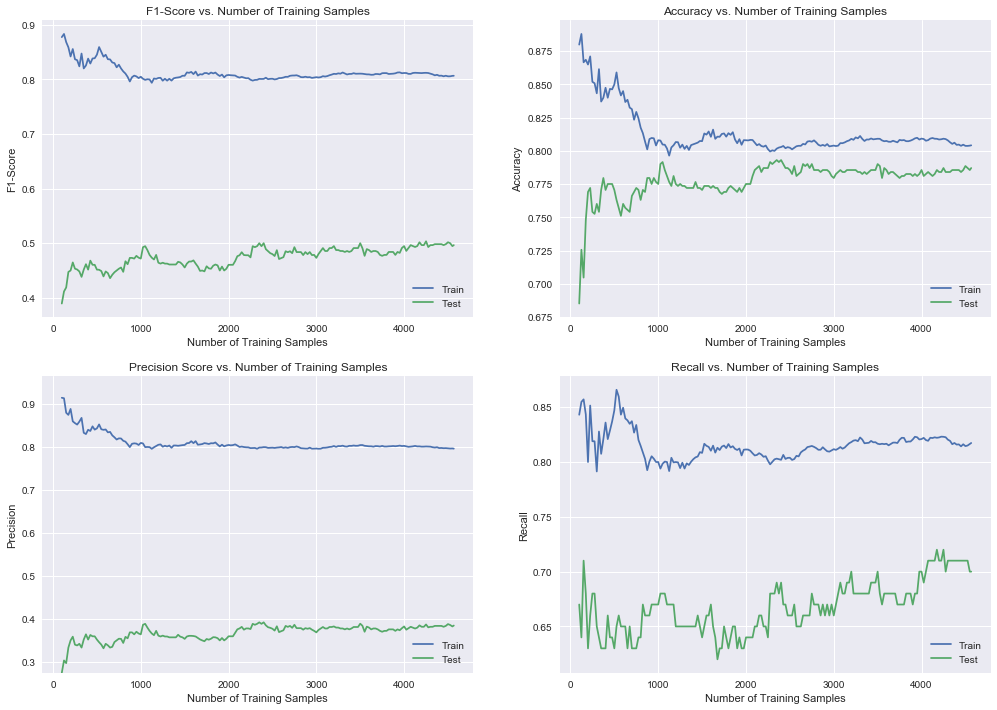

In [27]:
# let's see how well LR can fit and predict on the smote data
lr = LogisticRegression()
cv = cross_validation(lr, 
                      X_smote_onehot, 
                      Y_smote_onehot , 
                      n_splits=5, 
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test_onehot, Y_test_onehot)
cv.plot_learning_curve()

### Check for Understanding

1. Is this an improvement on the non-SMOTE OneHotEncoded data?
2. How did Precision change compared the non-SMOTE OneHotEncoded data ? What does this mean?
3. How did Accuracy change compared to the navie baseline? What does this mean?
4. How did Recall change? what does this mean?

1. Yes, this is an improvement. 
2. Precison has creaased by about 18%, peaking at 78%. This means that for every 10 users that are predicted of churning, 8 of them do actually churn. Our Baseline model performance has improved compared to the non-SMOTE OneHotEncoded data. 
3. The accuracy dropped by about 7 percent to 78%. This means that our model's accuracy is performing worse than our navie baseline. 
4. Recall increased a lot from 25% to about 79%. This means that our model is doing a better job at distinguishing between the two different classes. 

## 4rd Iteration | Balanced Classes on Scaled Data

In [28]:
# move churn column to Y 
# move all other columns to X
x_cols = df2.columns[:-1]
X = df2[x_cols].values
Y = df2.Churn.values

In [29]:
# no OneHotEncoding
sm = SMOTE(kind='regular')
X_smote_scaled, Y_smote_scaled = sm.fit_sample(X_train_scaled, Y_train_scaled)

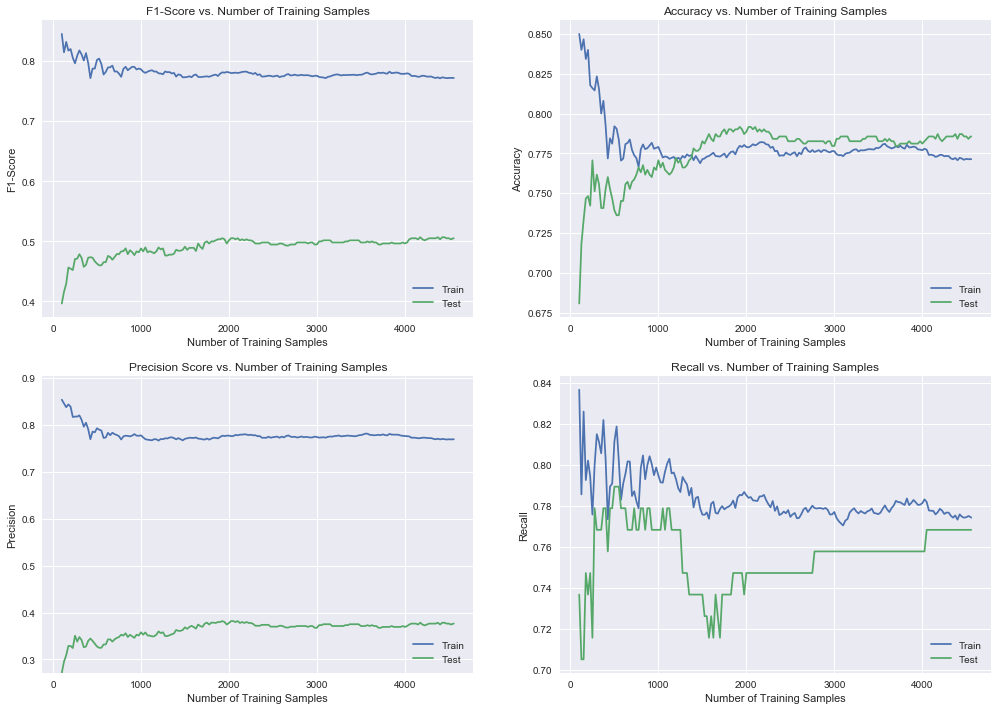

In [30]:
# let's see how well LR can fit and predict on the smote data
lr = LogisticRegression()
cv = cross_validation(lr, 
                      X_smote_scaled, 
                      Y_smote_scaled , 
                      n_splits=5, 
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")
cv.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv.plot_learning_curve()

### Check for Understanding

1. Is this an improvement on the non-SMOTE scaled data?
2. How did Precision change? What does this mean?
3. How did Accuracy change? What does this mean?
4. How did Recall change? what does this mean?

1. Yes, this is an improvement. 
2. Precison has creaased by about 18%, peaking at 79%. This means that for every 10 users that are predicted of churning, 8 of them do actually churn. Our Baseline model performance has improved compared to the non-SMOTE scaled data. 
3. The accuracy dropped by about 6 percent to 77%. This means that our model's accuracy is performing worse than our navie baseline. 
4. Recall increased a lot from 25% to about 78%. This means that our model is doing a better job at distinguishing between the two different classes. 

## Which version of the data set to use?

It appears that usign SMOTE on either of the original versions of the data set (scaled, scaled + OneHotEncoded) increases our baseline's model's recall scores dramatically. However, the accuracy drops to below the navie baseline as does the precisoin.

We also saw that the OneHotEncoded data increased the variance of LR. Since the OneHotEncoded version of the data doesn't perform better than the scaled version and the SMOTE OneHotEncoded version performs just as well. We are going to be parsimonious and moving forward the the scaled and SMOTE scaled versions of the data when training move complex models. 


---
## Optimize Models using Gridsearch


We saw in our baseline model that most of its error can be attributed to high bias. This is a justification for training move advance models that can hopefully capture the complexity of the data and perform well on all the metrics that we care about. 

We'll be using gridserach to optimize our models. Recall that gridsearch fits a models with every possible combination of parameters, identifying the unique set of parameters that leads to the best performing model. Gridsearch optimizes these models with respect to a single metric. Due to our business case, we will optimize these models with respect to precision.

--- 

## Optimze Models on Original Scaled Data

For our advance models, we'll be using Random Forest and Gradient Boosted Trees. 

### Random Forest

In [40]:
# instatiate model
rfc = RandomForestClassifier()
# fill a dictionary with different values for each hyper-parameter
rfc_params = {'max_depth': [None, 4, 6, 8],
              'min_samples_split': [2, 6, 10],
             'max_leaf_nodes': [None, 4, 6, 8]}

In [41]:
start = time()
gs_rf = GridSearchCV( rfc, rfc_params, scoring="precision", n_jobs=3, cv=10)
gs_rf.fit(X_train, Y_train)
end = time()
print (end - start)

15.0037209988


In [42]:
print gs_rf.best_params_
print gs_rf.best_score_

{'min_samples_split': 6, 'max_leaf_nodes': 6, 'max_depth': None}
0.956463416553


### Gradient Boosted Trees

In [43]:
# instatiate model
gbt = GradientBoostingClassifier()
# fill a dictionary with different values for each hyper-parameter
gbt_params = {'max_depth': [2, 4, 8, 10],
              'min_samples_split': [2,6,10],
              'max_leaf_nodes': [2, 4, 8, 12],
              "learning_rate" : [0.01, 0.1]}

In [44]:
start = time()
gs_gb = GridSearchCV( gbt, gbt_params, scoring="precision", n_jobs=3, cv=5)
gs_gb.fit(X_train, Y_train)
end = time()
print (end - start)

98.9560527802


In [45]:
print gs_gb.best_params_
print gs_gb.best_score_

{'min_samples_split': 2, 'max_leaf_nodes': 4, 'learning_rate': 0.01, 'max_depth': None}
1.0


## Optimize Models on SMOTE Scaled Data

For our advance models, we'll be using Random Forest and Gradient Boosted Trees. 

### Random Forest

In [72]:
# instatiate model
rfc = RandomForestClassifier()
# fill a dictionary with different values for each hyper-parameter
rfc_params = {'max_depth': [None, 4, 6, 8],
              'min_samples_split': [2, 6, 10],
             'max_leaf_nodes': [None, 4, 6, 8]}

In [73]:
start = time()
gs_rf_smote = GridSearchCV( rfc, rfc_params, scoring="precision", n_jobs=3, cv=10)
gs_rf_smote.fit(X_smote_scaled, Y_smote_scaled)
end = time()
print (end - start)

19.8274800777


In [74]:
print gs_rf_smote.best_params_
print gs_rf_smote.best_score_

{'min_samples_split': 2, 'max_leaf_nodes': None, 'max_depth': None}
0.962084128635


### Gradient Boosted Trees

In [76]:
# instatiate model
gbt = GradientBoostingClassifier()
# fill a dictionary with different values for each hyper-parameter
gbt_params = {'max_depth': [2, 4, 8, 10],
              'min_samples_split': [2,6,10],
              'max_leaf_nodes': [2, 4, 8, 12],
              "learning_rate" : [0.01, 0.1]}

In [77]:
start = time()
gs_gb_smote = GridSearchCV( gbt, gbt_params, scoring="precision", n_jobs=3, cv=5)
gs_gb_smote.fit(X_smote_scaled, Y_smote_scaled)
end = time()
print (end - start)

123.276492119


In [83]:
print gs_gb_smote.best_params_
print gs_gb_smote.best_score_

{'min_samples_split': 10, 'max_leaf_nodes': 12, 'learning_rate': 0.1, 'max_depth': 8}
0.968281058269


----

## Compare Model Performance


### Logistic Regression

As a reminder, let's get visualize LR's learning curves as a reminder.

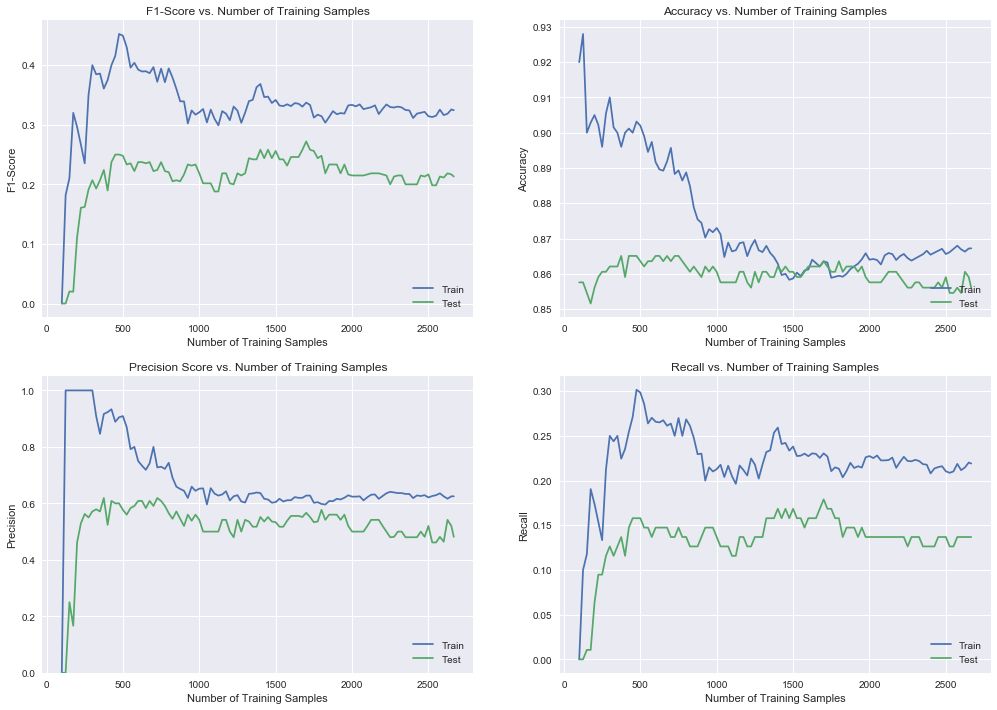

In [31]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, 
                      X_train_scaled, 
                      Y_train_scaled , 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv.plot_learning_curve()

### Random Forest

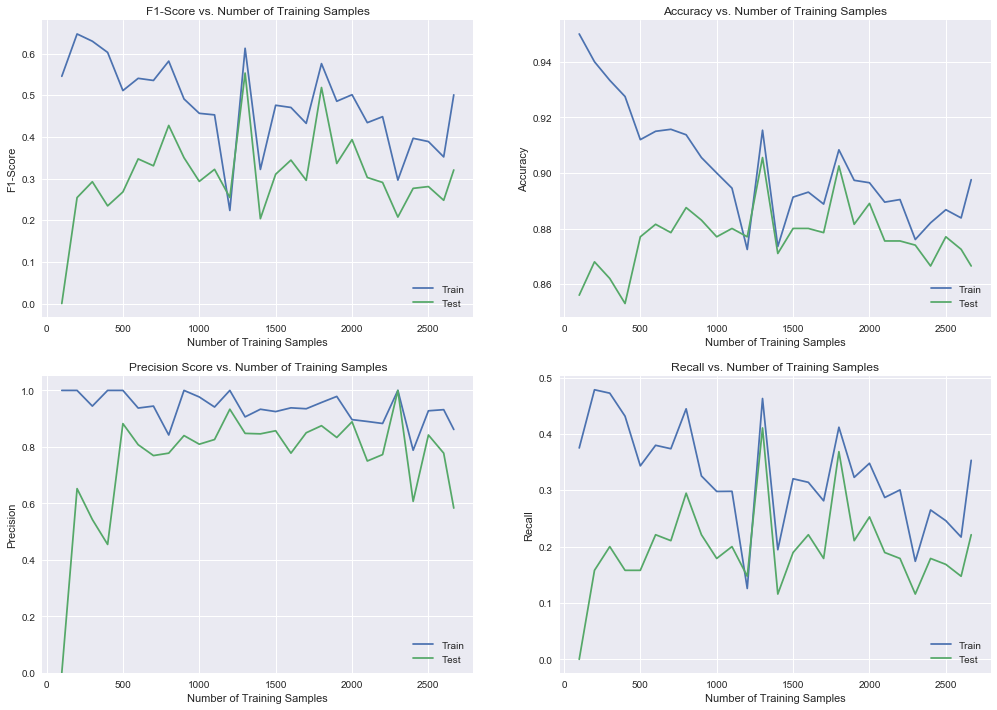

In [32]:
rfc = RandomForestClassifier(min_samples_split = 6, 
                             max_leaf_nodes = 6, 
                             max_depth = 2,
                             n_jobs=1)

cv_rfc = cross_validation(rfc, 
                          X_train_scaled, 
                          Y_train_scaled, 
                          n_splits=5,
                          init_chunk_size = 100, 
                          chunk_spacings = 100, 
                          average = "binary")

cv_rfc.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv_rfc.plot_learning_curve()

## Check for Understanding

1. Does the model have a high bias?
2. Does the model have a high variance?
3. Would increasing the size of the training set increase the model's performance?
4. Is the model overtraining? In order words, does the model's peak performance occur before the model is trained on the whole training set? 
5. How did Accuracy change? What does this mean?
6. How did Precisoin change? What does this mean?
7. How did Recall change? what does this mean?

1. The model does have some bias. We can see that from the flatline of the learning curves in all of the plots.
2. The model has a little more variance than our baseline, but not much. 
3. No. 
4. No.
5. The test accuracy is about 88.5 which is not much higher than the navie baseline of 85%. 
6. The Precison increase to about 90%. Which is a great improvement. This means that for very 10 users that are predicted to churn, 9 of them acutally to churn. 
7. The recall is very low, at about 25%. This means that the model has a difficult time distinguishing between the two classes. So although the precision is high, the model isn't actually identify too many positive cases. 

### Gradient Boosted Trees

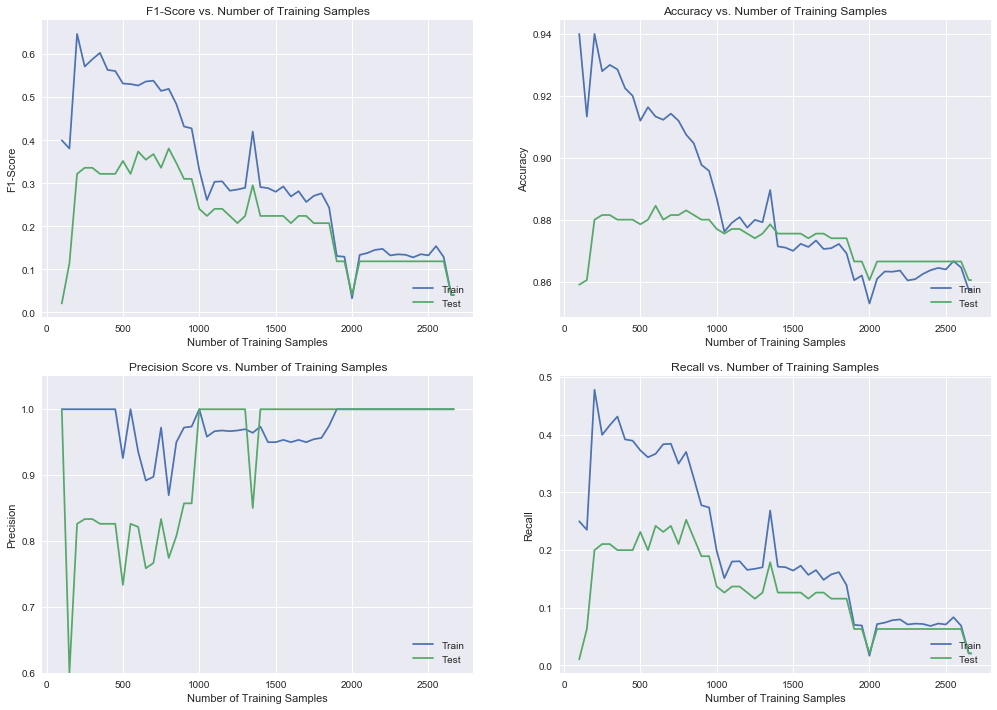

In [33]:
gbt = GradientBoostingClassifier(min_samples_split = 2, 
                                 max_leaf_nodes = 4, 
                                 learning_rate = 0.01, 
                                 max_depth = None)

cv_gbt = cross_validation(gbt, X_train_scaled, Y_train_scaled , 
                          n_splits=5, 
                          init_chunk_size = 100, 
                          chunk_spacings = 50, 
                          average = "binary")

cv_gbt.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv_gbt.plot_learning_curve()

## Check for Understanding

1. Does the model have a high bias?
2. Does the model have a high variance?
3. Would increasing the size of the training set increase the model's performance?
4. Is the model overtraining? In order words, does the model's peak performance occur before the model is trained on the whole training set? 

Gradient Boosted Trees is performing slighly worse than Random Forest.

## Compare Baseline Model with Advance Models | SMOTE Data

Let's fit each model with the unbalanced data set to see how it performance. 


### Don't use SMOTE data for the test set

Here we are training the model on the scaled SMOTE data and testing it on the scaled non-SMOTE data. We are doing this because the whole point of using SMOTE is for model training. Recall that SMOTE is balancing the classes in the training set, so they model can trained properly and not increase its biased due to class imbalances. Once the training is done, we can actually predict points one-by-one. In which case, there is not balancing to be done for two reasons: the model predicts labels for points individually, so there is not imbalance to speak of and, two, once we push this model into production, the model won't be predicting on synthetic points, it will only be predicting on real-world points so we want to test it's generalization accordingly. 

### Logistic Regression

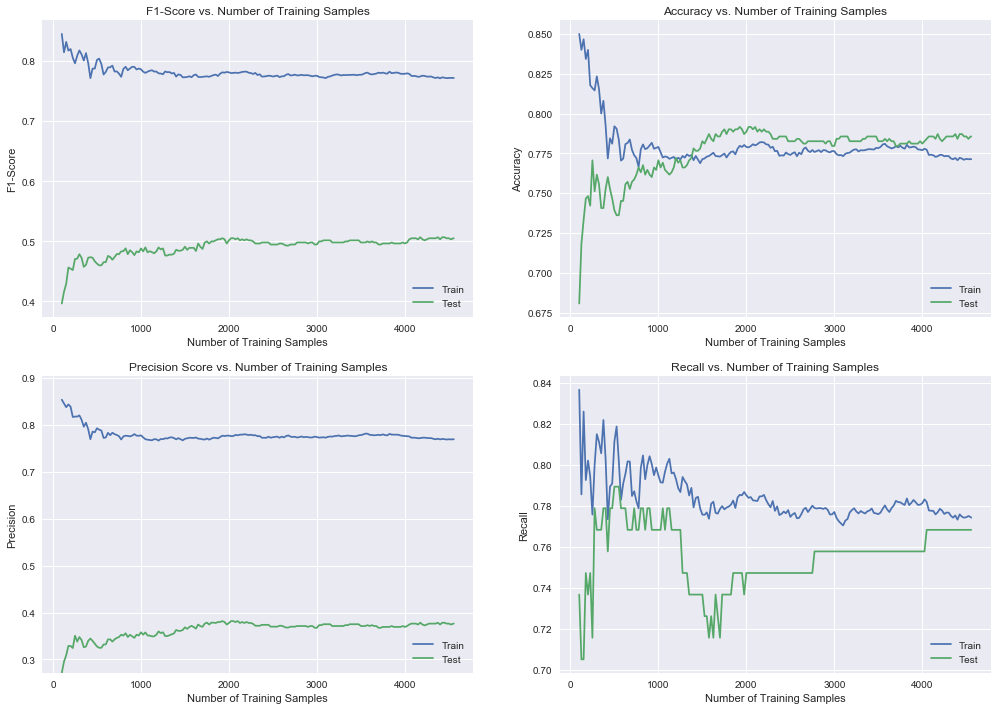

In [34]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, 
                      X_smote_scaled, 
                      Y_smote_scaled , 
                      n_splits=10,
                      init_chunk_size = 100, 
                      chunk_spacings = 25, 
                      average = "binary")

cv.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv.plot_learning_curve()

### Random Forest

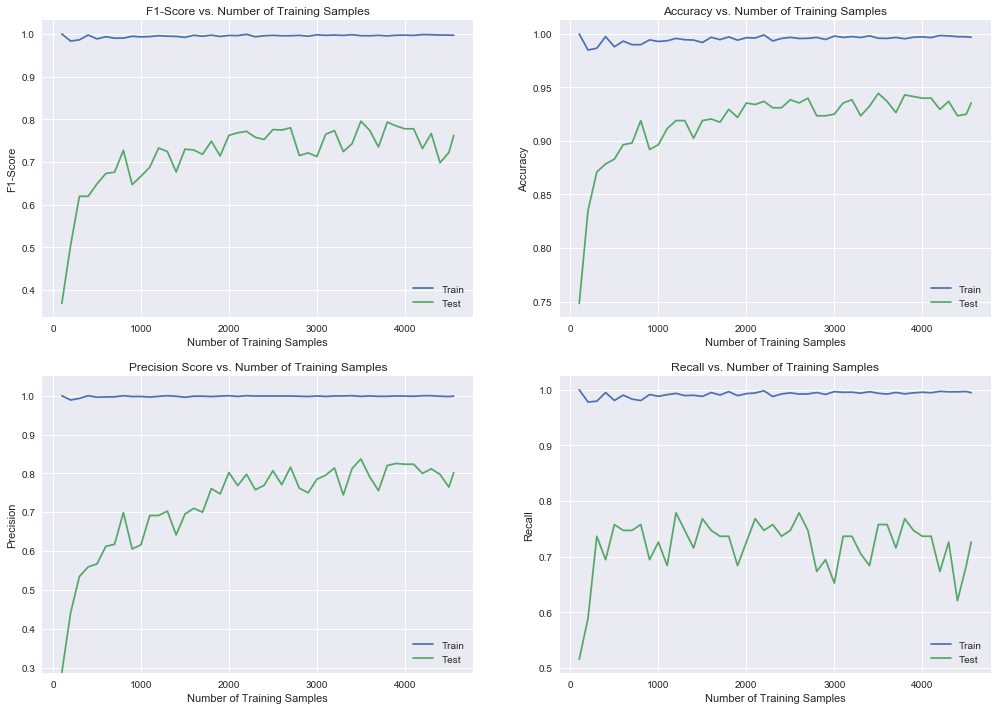

In [35]:
rfc = RandomForestClassifier(min_samples_split = 2, 
                             max_leaf_nodes = None, 
                             max_depth = None,
                             n_jobs=1)

cv_rfc = cross_validation(rfc, 
                          X_smote_scaled, 
                          Y_smote_scaled , 
                          n_splits=5,
                          init_chunk_size = 100, 
                          chunk_spacings = 100, 
                          average = "binary")

cv_rfc.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv_rfc.plot_learning_curve()

### Gradient Boosted Trees

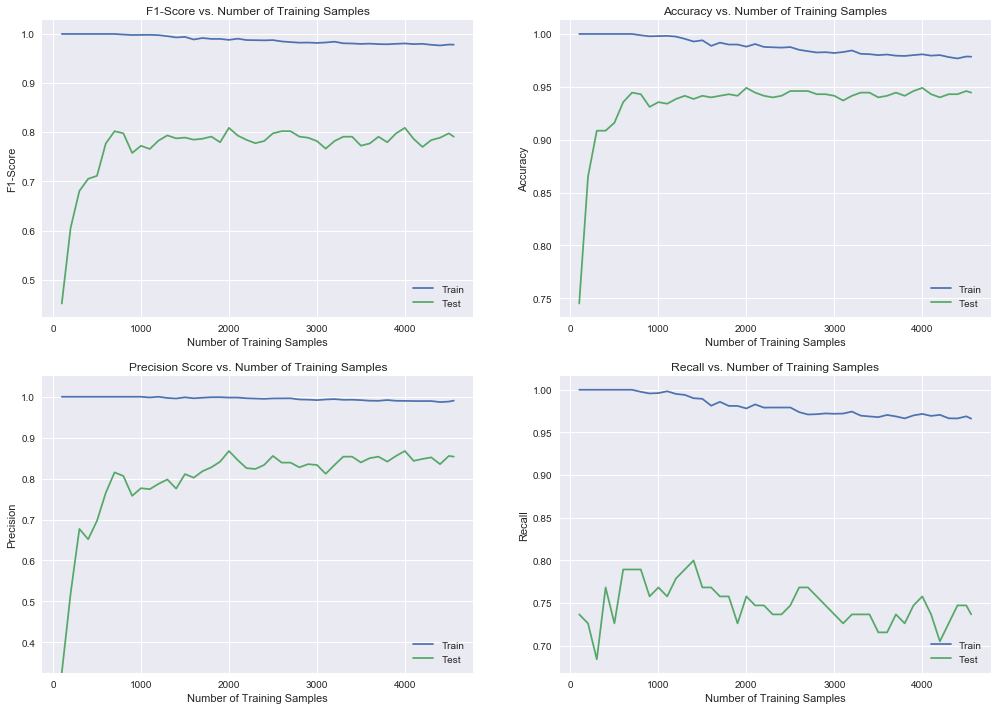

In [36]:
gbt = GradientBoostingClassifier(min_samples_split = 10, 
                                 max_leaf_nodes = 12, 
                                 learning_rate = 0.1, 
                                 max_depth = 8)

cv_gbt = cross_validation(gbt, 
                          X_smote_scaled, 
                          Y_smote_scaled , 
                          n_splits=5, 
                          init_chunk_size = 100, 
                          chunk_spacings = 100, 
                          average = "binary")

cv_gbt.validate_for_holdout_set(X_test_scaled, Y_test_scaled)
cv_gbt.plot_learning_curve()

## ROC Cruves

Let's plot the roc curves of all 6 models on the same viz and compare their performance. 

In [37]:
# models to train on original scaled data
lr = LogisticRegression(penalty='l2')

rfc = RandomForestClassifier(min_samples_split = 6, 
                             max_leaf_nodes = 6, 
                             max_depth = 2,
                             n_jobs=3)

gbt = GradientBoostingClassifier(min_samples_split = 2, 
                                 max_leaf_nodes = 4, 
                                 learning_rate = 0.01, 
                                 max_depth = None)

# models to train on SMOTE scaled data
rfc_smote = RandomForestClassifier(min_samples_split = 2, 
                             max_leaf_nodes = None, 
                             max_depth = None,
                             n_jobs=3)

gbt_smote = GradientBoostingClassifier(min_samples_split = 10, 
                                 max_leaf_nodes = 12, 
                                 learning_rate = 0.1, 
                                 max_depth = 8)

In [38]:
def get_probability(models_data_list):
    predicted_probs = []
    for model_data in models_data_list:
        model = model_data[0]
        X_train_data = model_data[1]
        Y_train_data = model_data[2]
        X_test_data = model_data[3]
        Y_test_data = model_data[4]
        
        model.fit(X_train_data, Y_train_data)
        # models pass back two columns: class1 -> probs for class 0, col2 -> probs for class 1
        y_probs = model.predict_proba(X_test_data).T[1]
        predicted_probs.append([Y_test_data, y_probs])
        
    return predicted_probs

### Note on Test Set for SMOTE

The purpose of SMOTE is to help the model learn the data on the training set. The test set is not transformed using SMOTE. Image that we deploy one of the models trained on the SMOTE into production code. The model would predict point-by-point. There wouldn't be any unbalancing to correct because the model wouldn't have made any predictions yet, and we would need those predictions to balance. Do you see how this is circular? That's why we don't transform the test set. 

In [39]:
model_data_list = ([lr, X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled],
                   [gbt, X_train_scaled, Y_train_scaled, X_test_scaled,Y_test_scaled], 
                   [rfc, X_train_scaled, Y_train_scaled, X_test_scaled,Y_test_scaled], 
                   [lr, X_smote_scaled, Y_smote_scaled, X_test_scaled, Y_test_scaled],
                   [rfc_smote, X_smote_scaled, Y_smote_scaled, X_test_scaled,Y_test_scaled],
                   [gbt_smote, X_smote_scaled, Y_smote_scaled, X_test_scaled,Y_test_scaled])

In [40]:
pred_probs = get_probability(model_data_list)

In [41]:
model_names = ["LR", "RF", "GBT", "LR-SMOTE", "RF-SMOTE",'GBT-SMOTE']

In [42]:
def plot_roc_curves(prob_list, model_names):
    fpr_list = []
    tpr_list = []
    auc_list = []
    for y_true, y_prob in prob_list:

        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        area_under_curve = auc(fpr, tpr)

        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(area_under_curve)

    x = np.arange(0,y_true.shape[0]+1, y_true.shape[0])
    y = x


    plt.figure(figsize = (16,8))
    plt.title("ROC Curve")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim(-0.01, 1.01)
    plt.ylim(0,1.01)
    
    for fpr, tpr, area_under_curve, model_name in zip(fpr_list, tpr_list, auc_list,  model_names):
        plt.plot(fpr, tpr,  label = "{}: AUC = {:.3}".format(model_name, area_under_curve));


    plt.plot(x,y,'--r');
    plt.legend(loc='lower right');

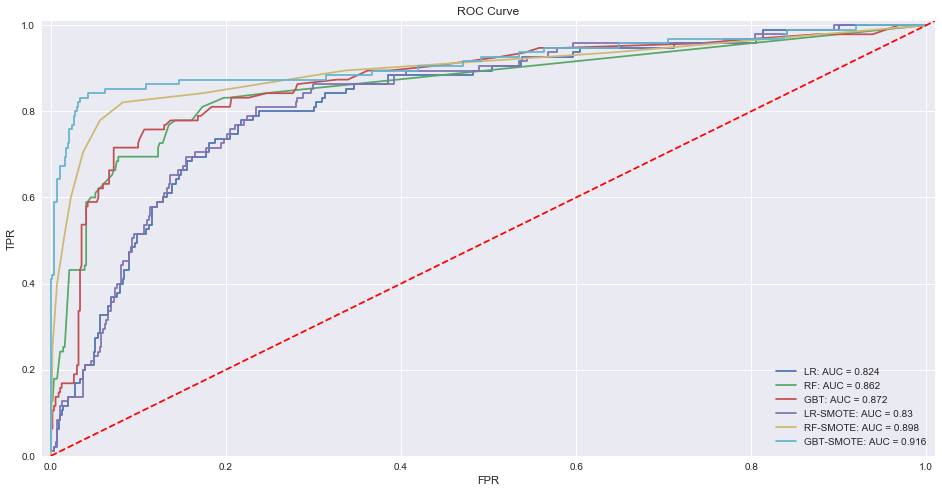

In [43]:
plot_roc_curves(pred_probs, model_names)

## Check for Understanding

1. Which model has the highest accuracy?

2. Each point on these curves is a probability threshold. As the probability threshold is changed from one percentage to another that is going to lead to a different confusion metrix with different vlaues for TP, FP, TN, FN. Yes, each point on each of these curves also represents a different confusion matrix. Which model has the best trade off between TP and FP? Why?
3. Based on your analysis, which model do you think is performning the best and why?

1. According to the ROC Curve, GBT trained on SMOTE data performs the best by a significant difference. 
2. GBT-SMOTE has the best trade off between TP and FP. We can see that GBT-SMOTE's TPR quickly rises to near one while the FPR is well below .10. 
3. Base on my analysis, I think that GBT-SMOTE is the best performing model. Since we are concerned with correclty identifying users to churn, we are interested in reducing the FP error. GBT-SMOTE reduces that error the most. 

### Scan Through Threshold Values

We are now going to use a function to scan through the probabilitiy threshold values that are plotted on the ROC Curve for GBT-SMOTE. 

In [259]:
def scan_roc_scores(tp_default, fp_default, y_true, y_prob):
    '''Iterate through the tpr, fpr, and threshold values of a roc curve
       and compare them to the default tp and fp of the classifer. 
       
       Return tp_rate_, fp_rate, thresholds, index if scores are better
       default.'''
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    index = 0
    for  tp_rate , fp_rate, thresh in zip(tpr, fpr, thresholds):
        if tp_rate >= tp_default and fp_rate <= fp_default:
            return tp_rate, fp_rate, thresh, index
        index += 1
    return "Default Results are better"

In [288]:
gbt_smote.fit(X_smote_scaled, Y_smote_scaled)
y_prob = gbt_smote.predict_proba(X_test_scaled).T[1]
y_hat = gbt_smote.predict(X_test_scaled)

In [353]:
tp_default = 0.78
fp_default = 0.008

tp_rate, fp_rate, thresh, index = scan_roc_scores(tp_default, fp_default, Y_test_scaled, y_prob)
tp_rate, fp_rate, thresh, index

(0.78021978021978022, 0.005208333333333333, 0.61026559578261297, 7)

In [354]:
# resort y predictions based on the new probability threshold 
y_hat_optimized = [1 if prob > thresh  else 0 for prob in y_prob]

### Confusion Matrix | Optimized Threshold

In [355]:
# |TN|FP|
# |FN|TP|

confusion_matrix(Y_test_scaled, y_hat_optimized)

array([[573,   3],
       [ 21,  70]])

### Confusion Matrix | Standard Threshold

In [356]:
# |TN|FP|
# |FN|TP|

confusion_matrix(Y_test_scaled, y_hat)

array([[567,   9],
       [ 17,  74]])

## Observations 

We can see that by dropping the probability threshold for labeling a data point as churn (positive) we have decreased the number of False Posivities dramatically. This is the usefulness of using the ROC Curve: we are able to "fine tune" the classifications for the positive class. 

---

## Feature Importance

Now that we have confirmed that Random Forest has reliable results. Let's use its feature importance method to find out which features are most predictive of churn. Use like Amazon and Uber, we can use information as actionable insight to help retain users and help aquire more users in the future. 

In [49]:
rfc_smote.fit(X_smote_scaled, Y_smote_scaled)

# create array of feture names for ploting
# call the array field_names
field_names = df2.columns.values[:-1]

# create array of feature importance weights from Random Forest
# call the array feat_weights
feat_weights = rfc_smote.feature_importances_

# use np.argsort to get an array of ordered indicies that can be used to 
# sort feature importance weights from largest to smallest
# call the array indices
indices = np.argsort(feat_weights)[::-1]

# Create a list comprehension that collects the feature importance values for every tree in the RF ensemble
# Hint: Use rfc.estimators_
# call the list feat_importance_trees
feat_importance_trees = [tree.feature_importances_ for tree in rfc_smote.estimators_]

# take the standard deviation of this list, this resulting list is the std value for each feature 
# call the array std
std = np.std(feat_importance_trees, axis=0) # std along the column

# create an int variable call n_features that is the numer of features in the feature set
n_features = len(feat_weights)

tick_marks_list = list(range(len(field_names)))

# create an array of sorted feature names
# call the array sorted_feat_names
sorted_feat_names =  np.array(field_names)[indices]

# create an array of soreted std 
# call the array sorted_std
sorted_std = std[indices]

# create an array of sorted feature weights
# call the array sorted_feat_weights
sorted_feat_weights = feat_weights[indices]

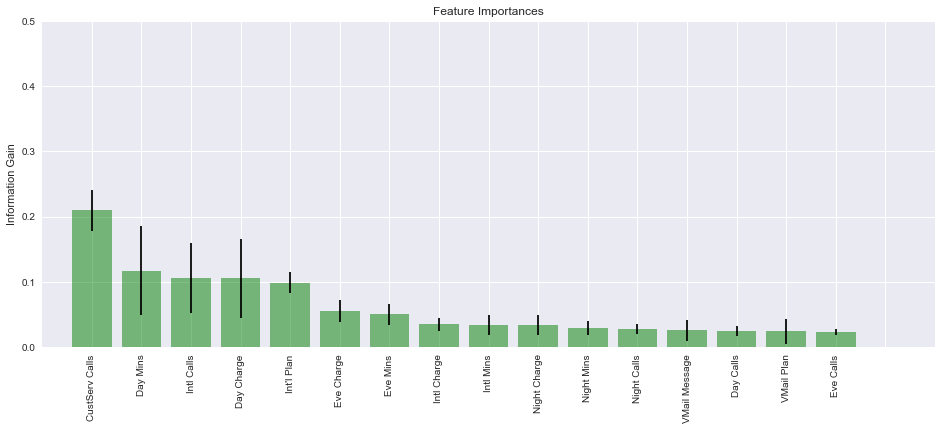

In [50]:
plt.figure(figsize=(16,6))
plt.title("Feature Importances")
plt.ylabel("Information Gain")
plt.bar(list(range(n_features)), sorted_feat_weights, color="g",alpha = 0.5, yerr=sorted_std, align="center")
plt.xticks(tick_marks_list, sorted_feat_names, rotation=90)
plt.xlim([-1, len(field_names)])
plt.ylim([0,0.5]);

## Check for Understanding

#### Interpreting Results

1. How would you explain these results to a junior data scientist that you are training?

2. How would you explain these results to a non-technical business leader?

1. Recall that Random Forest randomly selects a subset of features to split nodes on, those features that lead to the greatest information gain are used to split the node. If a majority of trees choose feature VMail Message to split the first node in the tree, then that feature is ranked as being most important because it is responsible for the most amount of information gain in the ensemble. The above plot is showing us that the two features on the far left are most predictive of user churn. We can use to information to desgin and inform our solution for minimizng churn. 

2.  The above plot is showing us that the two features on the far left are most predictive of user churn. Information Gain is simply a measure of how important each feature is in predicting churn. We can use this information to desgin and inform our solution for minimizng churn by targeting users based on these predictive features. 

### Interpret Results

Recall that Random Forest randomly selects a subset of features to split nodes on, those features that lead to the greatest information gain are used to split the node. If a majority of trees choose feature VMail Message to split the first node in the tree, then that feature is ranked as being most important because it is responsible for the most amount of information gain in the ensemble. 

### Correlation vs. Causality

![](https://imgs.xkcd.com/comics/correlation.png)

The information gain criteria say **NOTHING ABOUT CAUSATION**. 

For this reason we can't be sure that Day Charges directly cause churn. However, we can still use their importance to turn a profit! But before we can do that, we need to determine if Day Charges and Day Mins are positively or negativately correlated with churn. 

In [51]:
df2.corr()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan,VMail Plan,Churn
VMail Message,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,0.008745,0.956927,-0.089728
Day Mins,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.049396,-0.001684,0.205151
Day Calls,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.003755,-0.011086,0.018459
Day Charge,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.049398,-0.001686,0.205151
Eve Mins,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.019100,0.021545,0.092796
Eve Calls,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.006114,-0.006444,0.009233
Eve Charge,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987,0.019106,0.021559,0.092786
Night Mins,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288,-0.028905,0.006079,0.035493
Night Calls,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802,0.012451,0.015553,0.006141
Night Charge,0.007663,0.004300,0.022927,0.004301,-0.012593,-0.002056,-0.012601,0.999999,0.011188,1.000000,-0.015214,-0.012329,-0.015186,-0.009277,-0.028913,0.006064,0.035496


Since Day Charges are positively correlated with Churn, we can interpret this as user churn becomes likely has day charges increase. 


---

### Check for Understanding

1. How would you use all of these insights and your best performing model to reduce churn?
2. Would you desgin an experiment? What kind? Brainstrom several ideas. Be prepared to defend your idea in a class discussion.

### Testing for Effect

The good news is that we can test the insight that we derived from using Logistic Regression's Odds ratio. We can design an experiment in which coupons are sent to customers with high day time charges. One way to do this is to design a cost/benefit matrix which specifies the the money earned ( TP for churn )and the money lost (FP and FN) associated for each type of prediction. Then we can look at a ROC Curve and find an acceptible trade off between TP and FP, keeping in mind that TP means money earned and FP means money lost. We can then design two groups: the treatment group will consist of users that are predicted to turn, they will be emailed coupons good for a discount on Day Time Charges, the control group will consist of users that are predicted to churn but will not be emailed coupons. We can then perform a hypothesis test on the data that we collect after running this experiment. 

We would have to create a threshold, create a cost/benefit matrix, and plot a profit curve to know what portion of the population classied as positive for churn we need to send coupons to to maximize profits. 


## Actionable Insight and Profit Cruves

In order to apply our findings of the predictive probabilities and ROC Curve, we will create a profit curve. The first step to creating a profit curve is to construct a **cost benefit matrix.**

                    Features that are most predictive of Churn

                                    CustServCalls
                                    Day Charges
                                    Int'l Calls
                                    Day Mins
                                    
Let's say that we want to incentivize users that are predicted of churning to stay with a 10 dollar coupon good towards the purchase of 100 dollars worth of International Call minutes and/or Day time minutes. Ignoring Vail Messages, International Calls (Intl Calls) and Day time minutes (Day Mins) were ranked as the most important features (behind CustServCalls)that predict churn by the Logistic Regression classifier. Also let's say their is a 5 dollar cost to mailing the coupon. 


Case 1: If users are predicted to stay, do not mail coupon.

Case2:  If users are predicted to leave, then mail coupon and consider 2 sub-cases.

    Sub-case1: User buys, then the business makes a $85 profit and retains a user.

    Sub-case2: user doesn't buy, then the business loses $5 and a user. 
    
                      
                                     will buy  won't buy
                             leave   | $85    | -$15   |
                             stay    | $0     |  $0   |
                         
Rewriting this in a confusion matrix:

                                         Actual
                                     No churn  churn
            Prediction   No churn    |  TN = $0    |  FN = $0  |
                            churn    |  FP = $-15  |  TP = $85 |                        
                         
                         
                        confusion matrix has sklearn orientation:
                                     | TN | FP |
                                     | FN | TP |
                                     
>Sklearn: Binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.                                     

---

# Resources

Read all about **Profit Curves** here: [Data Science for Business](http://iiseb.knu.ac.kr/Lecture/2016/B.pdf). This text will explain the theory behind profit curves, how they are calculated, and how to interpret them. The text will also explains a lot of other data science tools: **ROC Curves**, **Unbalnced Classes**, ...

Precision Recall Case Study with Imbalanced Data Set [Case Study One](https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/) This article investigates the effects of an imbalanced data set on recall and precision. **TAKE AWAY:** ROC Curve analysis is limited and suffers with imbalanced data sets, where as Recall Precision Curves takes imbalanced labels into account. 

Precision Recall Case Study with Imbalanced Data Set [Case Study Two](https://classeval.wordpress.com/reanalysis-of-a-previous-study/) This case study revisits the analysis made in the Case Study One but with a different data set. 